<a href="https://colab.research.google.com/github/FunctionFreak/stabbing/blob/main/dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#spark session for pre processing

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Create a Spark session
spark = SparkSession.builder \
    .appName("Preprocessing with PySpark") \
    .getOrCreate()

# Check if the session is created
print("Spark session created successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b6140168af4cc66c68c117594cddd25b026b7a7f078599efd9ae7ebdfc460b46
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
Mounted at /content/drive
Spark session created successfully!


In [ ]:
#path for traning and validation

In [ ]:
import os
import shutil
from PIL import Image
# Define paths
train_image_dir = '/content/drive/My Drive/database/knifedataset/train/images'
train_label_dir = '/content/drive/My Drive/database/knifedataset/train/labels'
valid_image_dir = '/content/drive/My Drive/database/knifedataset/valid/images'
valid_label_dir = '/content/drive/My Drive/database/knifedataset/valid/labels'


In [ ]:

# Path for preprocessed data
preprocessed_data_dir = '/content/drive/My Drive/preprocesseddata'

# Check if the preprocessed data directory exists
if os.path.exists(preprocessed_data_dir):
    print("Folder 'preprocesseddata' exists. Start with training model.")
else:
    print("Folder 'preprocesseddata' does not exist. Starting preprocessing...")

    # Create the preprocessed data directory and its subdirectories if they do not exist
    os.makedirs(preprocessed_data_dir, exist_ok=True)

    preprocessed_train_image_dir = os.path.join(preprocessed_data_dir, 'train/images')
    preprocessed_train_label_dir = os.path.join(preprocessed_data_dir, 'train/labels')
    preprocessed_valid_image_dir = os.path.join(preprocessed_data_dir, 'valid/images')
    preprocessed_valid_label_dir = os.path.join(preprocessed_data_dir, 'valid/labels')

    os.makedirs(preprocessed_train_image_dir, exist_ok=True)
    os.makedirs(preprocessed_train_label_dir, exist_ok=True)
    os.makedirs(preprocessed_valid_image_dir, exist_ok=True)
    os.makedirs(preprocessed_valid_label_dir, exist_ok=True)

    # Define preprocessing functions
    def preprocess_image(image_path, save_path, size=(640, 640)):
        image = Image.open(image_path)
        image = image.resize(size)
        image.save(save_path)

    def copy_label(label_path, save_path):
        shutil.copy(label_path, save_path)

    # Preprocess data
    def preprocess_data(image_dir, label_dir, preprocessed_image_dir, preprocessed_label_dir, size=(640, 640)):
        # Preprocess images
        for image_name in os.listdir(image_dir):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):
                image_path = os.path.join(image_dir, image_name)
                save_image_path = os.path.join(preprocessed_image_dir, image_name)
                preprocess_image(image_path, save_image_path, size)

        # Copy label files
        for label_name in os.listdir(label_dir):
            if label_name.endswith('.txt'):
                label_path = os.path.join(label_dir, label_name)
                save_label_path = os.path.join(preprocessed_label_dir, label_name)
                copy_label(label_path, save_label_path)

    # Preprocess training data
    preprocess_data(train_image_dir, train_label_dir, preprocessed_train_image_dir, preprocessed_train_label_dir)

    # Preprocess validation data
    preprocess_data(valid_image_dir, valid_label_dir, preprocessed_valid_image_dir, preprocessed_valid_label_dir)



Folder 'preprocesseddata' exists. Start with training model.


In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install dependencies
!pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [ ]:
#Determine the Classes from the Labels
# Step 3: Determine the Classes from the Labels
import os
import glob

# Define the label directory paths
train_label_dir = '/content/drive/My Drive/preprocesseddata/train/labels'
valid_label_dir = '/content/drive/My Drive/preprocesseddata/valid/labels'

# Function to find all unique classes from label files
def find_unique_classes(label_dir):
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))
    classes = set()
    for label_file in label_files:
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                classes.add(class_id)
    return sorted(list(classes))

# Get unique classes from training and validation labels
train_classes = find_unique_classes(train_label_dir)
valid_classes = find_unique_classes(valid_label_dir)
all_classes = sorted(list(set(train_classes + valid_classes)))

# Create class names for the detected class indices
class_names = [f'class{cls}' for cls in all_classes]
print(f'Detected classes: {class_names}')

Detected classes: ['class0', 'class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7']


In [ ]:
# Step 4: Create the dataset YAML file
dataset_yaml = f"""
path: /content/drive/My Drive/preprocesseddata  # dataset root dir
train: train/images  # train images (relative to 'path')
val: valid/images  # val images (relative to 'path')

# Classes
nc: {len(all_classes)}  # number of classes
names: {class_names}  # class names
"""

with open('/content/yolov5/data/knife_dataset.yaml', 'w') as f:
    f.write(dataset_yaml)

In [ ]:
# Step 5: Train the YOLOv5 Model
!python train.py --img 640 --batch 16 --epochs 50 --data /content/yolov5/data/knife_dataset.yaml --cfg yolov5s.yaml --weights yolov5s.pt --name knife_detection

# Step 6: Evaluate the YOLOv5 Model
validation_images_path = '/content/drive/My Drive/preprocesseddata/valid/images'

# Run inference on the validation set
!python detect.py --weights runs/train/knife_detection/weights/best.pt --img 640 --conf 0.25 --source "{validation_images_path}"

2024-07-07 16:37:17.462407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 16:37:17.462452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 16:37:17.463973: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=/content/yolov5/data/knife_dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, 

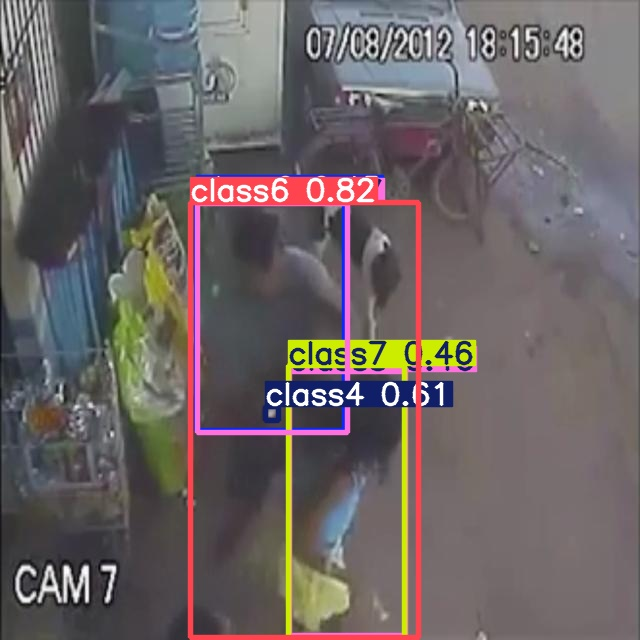

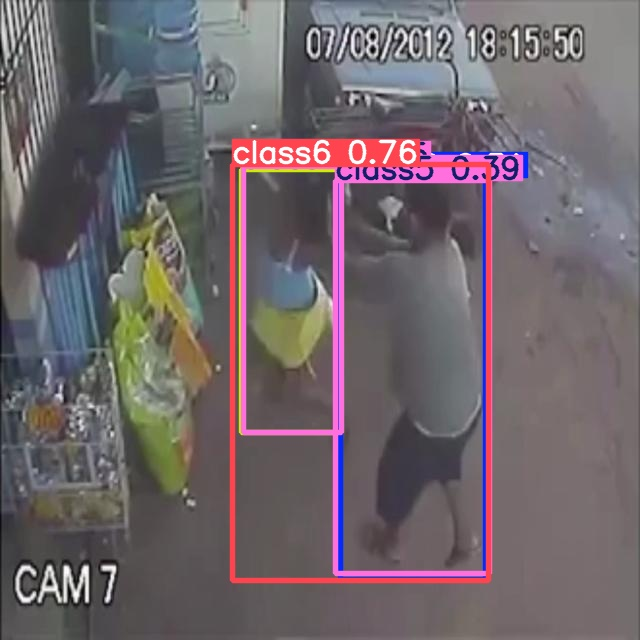

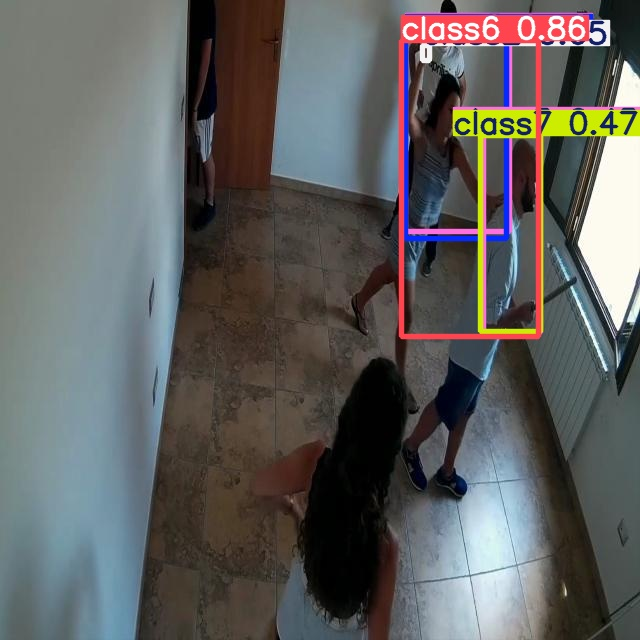

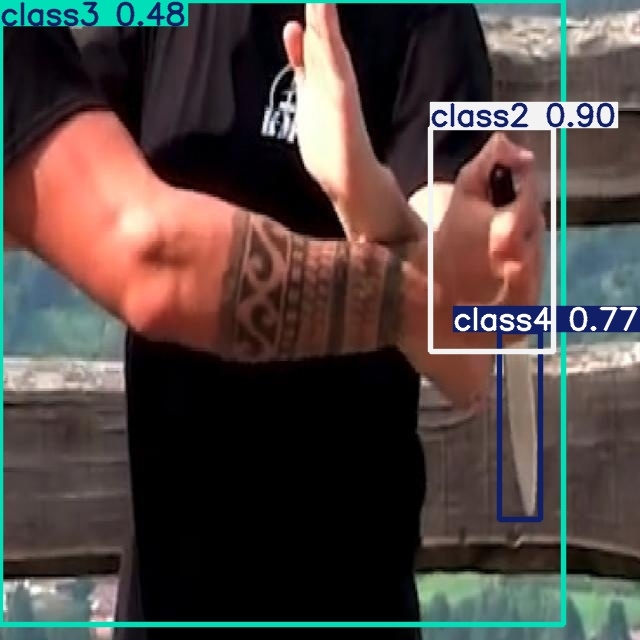

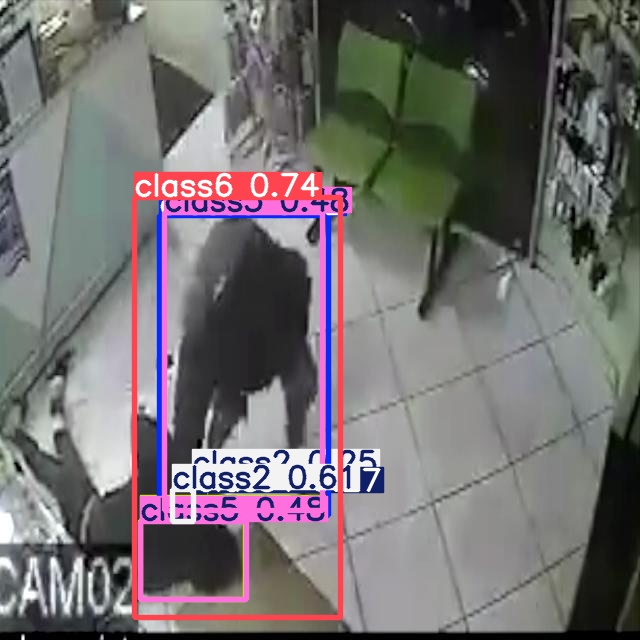

In [ ]:
# Display the Results
from IPython.display import Image, display
import glob

# List the detection results
result_images = glob.glob('runs/detect/exp/*.jpg')

# Display a few result images
for img_path in result_images[:5]:  # Displaying the first 5 result images
    display(Image(filename=img_path))

In [ ]:
import os
import shutil

# Create the directory in Google Drive, remove if it exists
trained_model_dir = '/content/drive/My Drive/trained_model'

# Remove the directory if it exists
if os.path.exists(trained_model_dir):
    shutil.rmtree(trained_model_dir)

# Create the directory
os.makedirs(trained_model_dir)

# Define the path to the best weights
best_weights_path = 'runs/train/knife_detection/weights/best.pt'

# Copy the best weights to the Google Drive directory
shutil.copy(best_weights_path, os.path.join(trained_model_dir, 'best.pt'))

print(f'Model saved to {os.path.join(trained_model_dir, "best.pt")}')

Model saved to /content/drive/My Drive/trained_model/best.pt


In [ ]:
import torch

# Path to the saved model in Google Drive
model_path = '/content/drive/My Drive/trained_model/best.pt'

# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0', 'requests>=2.32.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 146.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 241.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 237.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 7.5s, installed 3 packages: ['gitpython>=3.1.30', 'pillow>=10.3.0', 'requests>=2.32.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-7-7 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7031701 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [ ]:
# create a web page
from IPython.display import display, HTML
import threading
import socket
import base64
import cv2
import numpy as np
from flask import Flask, request, jsonify

# Write the HTML content to a file
html_content = """
<!DOCTYPE html>
<html>
<head>
    <title>Webcam Access</title>
</head>
<body>
    <h1>Webcam Stream</h1>
    <video id="video" width="640" height="480" autoplay></video>
    <button id="snap">Capture</button>
    <canvas id="canvas" width="640" height="480"></canvas>

    <script>
        // Access the webcam stream
        var video = document.getElementById('video');
        if (navigator.mediaDevices && navigator.mediaDevices.getUserMedia) {
            navigator.mediaDevices.getUserMedia({ video: true }).then(function(stream) {
                video.srcObject = stream;
                video.play();
            });
        }

        // Capture the video frame
        var canvas = document.getElementById('canvas');
        var context = canvas.getContext('2d');
        document.getElementById('snap').addEventListener('click', function() {
            context.drawImage(video, 0, 0, 640, 480);
            var dataURL = canvas.toDataURL('image/png');
            fetch('/upload_image', {
                method: 'POST',
                body: JSON.stringify({ image: dataURL }),
                headers: {
                    'Content-Type': 'application/json'
                }
            }).then(response => response.json())
              .then(data => {
                if (data.stabbing_detected) {
                    alert('Stabbing detected!');
                } else {
                    alert('No stabbing detected.');
                }
            });
        });
    </script>
</body>
</html>
"""

with open('webcam.html', 'w') as f:
    f.write(html_content)

# Start a simple HTTP server to serve the HTML
app = Flask(__name__)

@app.route('/')
def index():
    return open('webcam.html').read()

@app.route('/upload_image', methods=['POST'])
def upload_image():
    data = request.json['image']
    # Decode the image
    header, encoded = data.split(",", 1)
    img_data = base64.b64decode(encoded)
    img_array = np.frombuffer(img_data, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    # Here, you would integrate your model to perform inference on the image
    # For now, let's assume there's no stabbing detected
    # Replace the following line with your model inference code
    stabbing_detected = False

    return jsonify({'stabbing_detected': stabbing_detected})

def run_app():
    app.run(host='0.0.0.0', port=5000)

# Start the Flask server in a new thread
threading.Thread(target=run_app).start()

# Display a clickable link
display(HTML('<a href="http://localhost:5000" target="_blank">Click here to open webcam page</a>'))

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
